In [586]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import seaborn as sns                                                   
import sys             
from sympy import *                           
from scipy import stats
import pandas as pd
import os
from importlib import reload
import tensorflow as tf
import tensorflow_probability as tfp
import time

plt.style.use("../KD_style.mplstyle")

In [308]:
# Generate HMC data

def unnormalized_log_prob(*xs):
        return tf.math.add_n([-(x - mu)**2/(2*sigma**2) for x, mu, sigma in zip(xs, mus, sigmas)])
def test_leapfrog(leap_num):
    num_results = int(10e3)
    num_burnin_steps = int(1e3)
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_prob,
            num_leapfrog_steps=leap_num,
            step_size=list(sigmas/5)),
        num_adaptation_steps=int(num_burnin_steps * 0.8))
    
    # Run the chain (with burn-in).
    @tf.function
    def run_chain():
        # Run the chain (with burn-in).
        samples, is_accepted = tfp.mcmc.sample_chain(
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            current_state=[1. for i in range(dim)],
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
        return samples, is_accepted

    samples = run_chain()
    return samples

np.random.seed(42)
dim = 50
mus = [0 for i in range(dim)]
sigmas = np.linspace(0.01,1,dim)

leap_n = 20
samples, accepted = test_leapfrog(leap_n)
print(np.sum(accepted)/10e3)

267.804301738739 [-248010.34]
0.7703


In [ ]:
# save HMC data

df = pd.DataFrame(np.array(samples)[:,accepted]).T
print([f"{i} {mu} {round(sigma)}" for i, mu, sigma in zip(range(1, dim+1), mus, sigmas)])
df.columns = [f"{i} {mu} {round(sigma)}" for i, mu, sigma in zip(range(1, dim+1), mus, sigmas)]
# df.to_csv("./HMC_sample_50d_10000points_variedsigma.csv", index= None)

In [452]:
def running_chi2(data, mus, sigmas, bins= 100, interval=100):
    data = np.array(data)
    n_calcs = int((data.shape[1]-1)/interval)
    print(n_calcs)
    chi2_means = np.zeros(n_calcs)
    chi2_std = np.zeros(n_calcs)
    ps = np.zeros(n_calcs)
    for run in range(0, n_calcs):
        temp_chi2 = np.zeros(data.shape[0])
        temp_p = np.zeros(data.shape[0])
        for idx, (row, mu, sigma) in enumerate(zip(data[:, :(run+1) * interval], mus, sigmas)):
            count, edge = np.histogram(row, bins = bins)
            center = (edge[1:] + edge[:-1])/2
            mask = count > 0
            x = center[mask]
            y = count[mask]
            sy = np.sqrt(y)
            # print(y)
            scale = (np.max(row)-np.min(row))/bins*(run+1) * interval
            expected = stats.norm.pdf(x, mu, sigma)*scale
            chi2 = np.sum((expected-y)**2/sy**2)
            temp_chi2[idx] = chi2
            temp_p[idx] = stats.ch  i2.sf(chi2, np.sum(mask))
        chi2_means[run] = np.mean(temp_chi2)
        chi2_std[run] = np.std(temp_chi2)
        ps[run] = np.mean(temp_p)
    print(np.argmax(temp_chi2))
    print(np.argmin(temp_chi2))
    return chi2_means, chi2_std, ps
# samples = pd.read_csv("./HMC_sample_50d_10000points.csv").values.T
mus = [0 for i in range(dim)]
sigmas = np.linspace(0.01,1,dim)
# means, std, ps= running_chi2(np.array(samples)[:,accepted], mus, sigmas, bins =100, interval = 100)
# eans[]
# print(means[21], std[21])

In [588]:
sam_array = pd.read_csv("./HMC_sample_50d_10000points_variedsigma.csv").values.T

IndexError: boolean index did not match indexed array along dimension 1; dimension is 8000 but corresponding boolean dimension is 10000

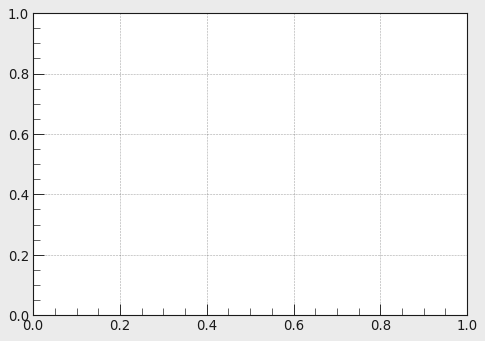

In [501]:
fig, ax = plt.subplots()
ax.errorbar(np.linspace(0, np.array(samples)[:,accepted].shape[1], len(means)), means, yerr = std)
# print(len())
ax2 = ax.twinx()
ax2.plot(np.linspace(0, np.array(samples)[:,accepted].shape[1], len(ps)), ps, color = "k")
ax.set_ylabel("Average $\chi^{2}$")
ax.set_xlabel("Iteration")
ax2.set_ylabel("Average p-value")
ax.grid(False)
ax2.grid(False)
plt.show()

In [ ]:
mh_samples = pd.read_csv("./accept_samples").values.T
uniques = np.unique(mh_samples[0]).shape[0]
print(uniques)
new_data = np.zeros((50, uniques))
for idx, row in enumerate(mh_samples):
    new_data[idx, :] = np.unique(row)
mus = [0 for i in range(dim)]
sigmas = np.linspace(0.01, 1, 50)
means, std = running_chi2(new_data, mus, sigmas, bins =100, interval = 100)
print(means[-1], std[-1])
plt.hist(new_data[20], bins = 30)
plt.show()
plt.errorbar(np.linspace(0, new_data.shape[1], len(means)), means, yerr = std)
plt.ylabel("Average $\chi^{2}$")
plt.xlabel("Iteration")

In [378]:

def unnormalized_log_prob(x_range, mu_range=[0]*50, sigma_range=np.linspace(0.01,1,50)):
    return np.prod([(1 / (sigma*np.sqrt(2*np.pi))) * np.exp(-((x-mu)**2)/(2*(sigma**2))) for x,mu,sigma in zip(x_range,mu_range,sigma_range)])

def metropolis_hastings(theta_old, theta_cand, accept):
    posterior_old = unnormalized_log_prob(theta_old)
    posterior_cand = unnormalized_log_prob(theta_cand)
    r = posterior_cand / posterior_old
    acceptance = [1, r]
    p = np.min(acceptance)
    choice = np.random.choice([0, 1], p=[p,1-p])
    return (theta_cand, True) if choice == 0 else (theta_old, False)

def mcmc_mh(init_guess, steps, mu_range, sigma_range, burn_in_percent=0.2):
    theta_array = np.zeros((len(init_guess),steps))
    theta_array[:,0] = init_guess
    theta_old = np.copy(init_guess)
    steps_burn = int(np.floor(steps*burn_in_percent))
    accepts = np.zeros(steps, dtype = bool)
    accept = 0
    for step in range(1,steps):
        theta_cand = [x + stats.norm.rvs(mu, sigma) for  x, mu, sigma in zip(theta_old,mu_range,sigma_range)]
        theta_new, accept = metropolis_hastings(theta_old, theta_cand, accept)
        theta_old = np.copy(theta_new)
        accepts[step] = accept
        theta_array[:, step] = theta_new
        print(f"Accept_rate = {np.sum(accepts)/step:.2%}")
    theta_burn = theta_array[:,:steps_burn]
    theta_sample = theta_array[:,steps_burn:]
    return theta_sample, accepts[steps_burn:]

theta_array, accepts = mcmc_mh([0.1]*50, 40000, mu_range=[0]*50, sigma_range=np.linspace(0.01,1,50)/3)



Accept_rate = 100.00%
Accept_rate = 100.00%
Accept_rate = 100.00%
Accept_rate = 75.00%
Accept_rate = 60.00%
Accept_rate = 50.00%
Accept_rate = 42.86%
Accept_rate = 37.50%
Accept_rate = 33.33%
Accept_rate = 30.00%
Accept_rate = 36.36%
Accept_rate = 41.67%
Accept_rate = 46.15%
Accept_rate = 42.86%
Accept_rate = 40.00%
Accept_rate = 37.50%
Accept_rate = 41.18%
Accept_rate = 38.89%
Accept_rate = 36.84%
Accept_rate = 35.00%
Accept_rate = 33.33%
Accept_rate = 36.36%
Accept_rate = 34.78%
Accept_rate = 33.33%
Accept_rate = 32.00%
Accept_rate = 30.77%
Accept_rate = 29.63%
Accept_rate = 28.57%
Accept_rate = 27.59%
Accept_rate = 26.67%
Accept_rate = 25.81%
Accept_rate = 25.00%
Accept_rate = 24.24%
Accept_rate = 23.53%
Accept_rate = 25.71%
Accept_rate = 27.78%
Accept_rate = 27.03%
Accept_rate = 26.32%
Accept_rate = 25.64%
Accept_rate = 25.00%
Accept_rate = 24.39%
Accept_rate = 23.81%
Accept_rate = 25.58%
Accept_rate = 27.27%
Accept_rate = 26.67%
Accept_rate = 26.09%
Accept_rate = 25.53%
Accept_rat

In [506]:
mus, sigmas =[0]*50, np.linspace(0.01,1,50)
df = pd.DataFrame(theta_array[:,accepts]).T
print([f"{i} {mu} {round(sigma,3)}" for i, mu, sigma in zip(range(1, dim+1), mus, sigmas)])
df.columns = [f"{i} {mu} {round(sigma,3)}" for i, mu, sigma in zip(range(1, dim+1), mus, sigmas)]
df.to_csv("./MHS_around_8000_good_accepted.csv", index= None)

['1 0 0.01', '2 0 0.03', '3 0 0.05', '4 0 0.071', '5 0 0.091', '6 0 0.111', '7 0 0.131', '8 0 0.151', '9 0 0.172', '10 0 0.192', '11 0 0.212', '12 0 0.232', '13 0 0.252', '14 0 0.273', '15 0 0.293', '16 0 0.313', '17 0 0.333', '18 0 0.353', '19 0 0.374', '20 0 0.394', '21 0 0.414', '22 0 0.434', '23 0 0.454', '24 0 0.475', '25 0 0.495', '26 0 0.515', '27 0 0.535', '28 0 0.556', '29 0 0.576', '30 0 0.596', '31 0 0.616', '32 0 0.636', '33 0 0.657', '34 0 0.677', '35 0 0.697', '36 0 0.717', '37 0 0.737', '38 0 0.758', '39 0 0.778', '40 0 0.798', '41 0 0.818', '42 0 0.838', '43 0 0.859', '44 0 0.879', '45 0 0.899', '46 0 0.919', '47 0 0.939', '48 0 0.96', '49 0 0.98', '50 0 1.0']


In [503]:
dim = 50
mu_range = np.zeros(dim)
sigma_range=np.linspace(0.01,1,dim)
print(theta_array[:, accepts])
mean_MH, std_MH, ps_MH= running_chi2(theta_array[:, accepts], mu_range, sigma_range, bins =100, interval = 100)
print(mean_MH)

[[-1.22139442e-02 -8.66829744e-03 -6.89435465e-03 ...  4.02827558e-03
   6.58415795e-04  8.05176115e-03]
 [ 1.23434407e-03  4.88467059e-03 -1.36605573e-03 ... -7.50313961e-03
   3.19631562e-04  8.85194865e-04]
 [ 1.09716273e-01  1.24953050e-01  1.21890001e-01 ... -5.71209535e-02
  -4.34308937e-02 -3.94134654e-02]
 ...
 [-8.46201316e-01 -7.26871889e-01 -6.57777255e-01 ...  3.92046002e-01
   4.82701676e-01  3.27061116e-01]
 [ 3.76507128e-01 -5.57445510e-02 -4.55811787e-01 ...  8.75932602e-01
   1.37460333e+00  1.11959638e+00]
 [-5.69547493e-01 -5.97683035e-01 -5.68614844e-01 ...  1.52086692e+00
   1.13764416e+00  1.17615040e+00]]
76
2
3
[ 35.07978532  77.23748343 126.45722508 141.62168851 157.50689844
 166.91288195 175.22468614 184.95970204 188.36023363 189.03498621
 193.72525965 187.23220716 189.79140986 185.61385002 176.29716257
 180.77175736 179.04273666 174.23121641 171.12408733 168.71281485
 173.8735541  181.22354472 185.62366841 183.12458951 183.3435293
 182.08953908 184.29509774 1

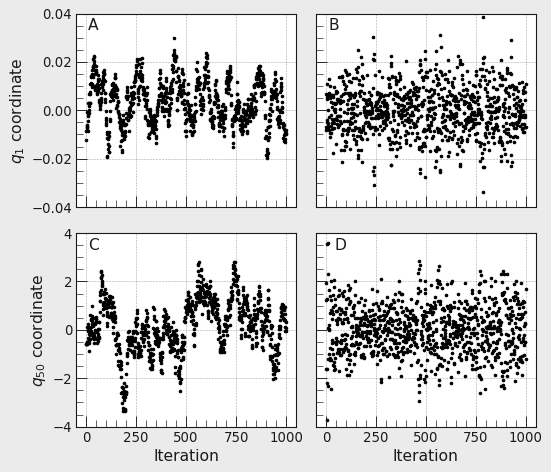

In [715]:
fig, axes = plt.subplots(2,2, figsize = (7, 6), sharey="row", sharex=True)
iters = 1000
ax1 = axes[1][0]
ax1.scatter(range(iters), theta_array[:, accepts][-1, :iters], s = 20, color = "k")
ax1.set(xlabel = "Iteration", ylabel = r"$q_{50}$ coordinate")
ax1.set_ylim((-4, 4))
ax1.text(10, 3.3, "C", fontsize = 14)
ax2 = axes[1][1]
ax2.scatter(range(iters), sam_array[-1, :iters], s = 20, color = "k")
ax2.set(xlabel = "Iteration")
ax2.text(40, 3.3, "D", fontsize = 14)
ax3 = axes[0][0]
ax3.scatter(range(iters), theta_array[:, accepts][0, :iters], s = 20, color = "k")
ax3.set(ylabel = r"$q_{1}$ coordinate")
ax3.set_ylim((-0.04, 0.04))
ax3.text(10, 0.033, "A", fontsize = 14)
ax4 = axes[0][1]
ax4.scatter(range(iters), sam_array[0, :iters], s = 20, color = "k")
ax4.text(10, 0.033, "B", fontsize = 14)
plt.tight_layout()
plt.savefig("MHS_vs_HMC_1st_and_50th_dim_first_1000points.pdf", facecolor = "white")

In [591]:
print(np.linspace(0.01, 1, 50))

[0.01       0.03020408 0.05040816 0.07061224 0.09081633 0.11102041
 0.13122449 0.15142857 0.17163265 0.19183673 0.21204082 0.2322449
 0.25244898 0.27265306 0.29285714 0.31306122 0.33326531 0.35346939
 0.37367347 0.39387755 0.41408163 0.43428571 0.4544898  0.47469388
 0.49489796 0.51510204 0.53530612 0.5555102  0.57571429 0.59591837
 0.61612245 0.63632653 0.65653061 0.67673469 0.69693878 0.71714286
 0.73734694 0.75755102 0.7777551  0.79795918 0.81816327 0.83836735
 0.85857143 0.87877551 0.89897959 0.91918367 0.93938776 0.95959184
 0.97979592 1.        ]


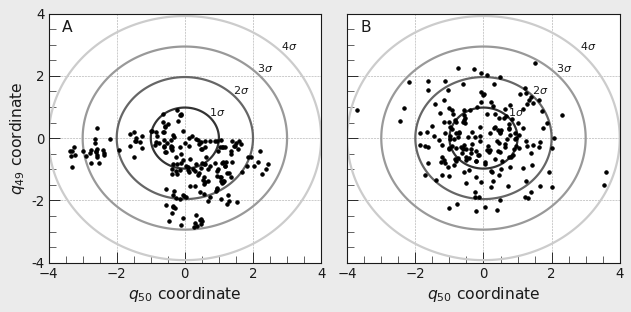

In [684]:
def gauss(points, mu, sigma):
    return 1/np.sqrt(np.pi*2)*np.exp(-1/2*(points-mu)**2/sigma**2)

def double_gauss(points, mus = [0,0], sigmas = [1, 0.9798]):
    return  gauss(points[0], mus[0], sigmas[0]) * gauss(points[1], mus[1], sigmas[1])

q50_range = np.round(np.linspace(-4, 4, 1001),3)
q49_range = np.round(np.linspace(-4, 4, 1001),3)
mesh = np.meshgrid(q50_range, q49_range)
xx, yy = mesh
Z = double_gauss(np.array([xx, yy]))
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4), sharey = True, sharex = True)
iters = 200
sigma_values = list(reversed(double_gauss(0.707*np.array([[1,2,3,4], [0.9798, 0.9798*2, 0.9798*3, 0.9798*4]]))))
ax1.contour(xx, yy, Z, levels = sigma_values, colors = list(reversed(["#333333", "#666666", "#999999", "#cccccc"])))
ax1.scatter(theta_array[:, accepts][-1, :iters], theta_array[:, accepts][-2, :iters], linewidth = 1, color = "k", zorder = 10)
ax1.set(ylabel = r"$q_{49}$ coordinate", xlabel = r"$q_{50}$ coordinate")

cos_pi_4th = 0.707
ax1.text(-3.6, 3.4, "A", fontsize = 14)
ax1.text(1*cos_pi_4th , 1*cos_pi_4th , r"1$\sigma$", fontsize = 10)
ax1.text(2*cos_pi_4th , 2*cos_pi_4th , r"2$\sigma$", fontsize = 10)
ax1.text(3*cos_pi_4th , 3*cos_pi_4th , r"3$\sigma$", fontsize = 10)
ax1.text(4*cos_pi_4th , 4*cos_pi_4th , r"4$\sigma$", fontsize = 10)
ax1.set_yticks([-4, -2, 0, 2, 4])
ax1.set_yticklabels([-4, -2, 0, 2, 4])
ax2.contour(xx, yy, Z, levels = sigma_values, colors = list(reversed(["#333333", "#666666", "#999999", "#cccccc"])))
ax2.scatter(sam_array[-1, :iters], sam_array[-2, :iters], linewidth = 1, color = 'k', zorder = 5)
ax2.set(xlabel = r"$q_{50}$ coordinate")
ax2.text(-3.6, 3.4, "B", fontsize = 14)
ax2.text(1*cos_pi_4th , 1*cos_pi_4th , r"1$\sigma$", fontsize = 10, zorder = 10)
ax2.text(2*cos_pi_4th , 2*cos_pi_4th , r"2$\sigma$", fontsize = 10)
ax2.text(3*cos_pi_4th , 3*cos_pi_4th , r"3$\sigma$", fontsize = 10)
ax2.text(4*cos_pi_4th , 4*cos_pi_4th , r"4$\sigma$", fontsize = 10)
plt.tight_layout()
plt.savefig("MHS_vs_HMC_50th_vs_49th_first_200_good.pdf", facecolor = "white")

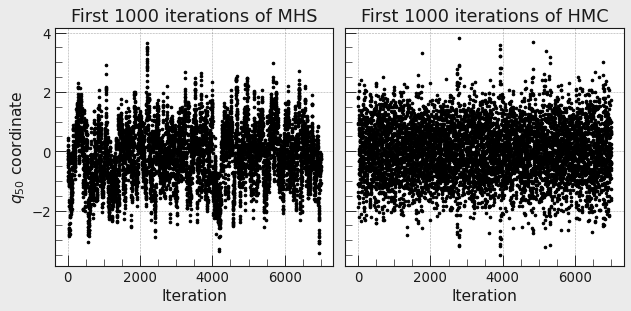

In [579]:
fig, axes = plt.subplots(1,2, figsize = (8,4), sharey=True)
iters = 7000
ax1 = axes[0]
ax1.scatter(range(iters), theta_array[:, accepts][-2, :iters], s = 20, color = "k")
ax1.set(xlabel = "Iteration", ylabel = r"$q_{50}$ coordinate", title = "First 1000 iterations of MHS")
ax2 = axes[1]
ax2.scatter(range(iters), sam_array[-2, :iters], s = 20, color = "k")
ax2.set(xlabel = "Iteration", title = "First 1000 iterations of HMC")
plt.tight_layout()
# plt.savefig("MHS_vs_HMC_50thdim_first_1000.pdf", facecolor = "white")

In [510]:
sam_array = pd.read_csv("./HMC_sample_50d_10000points_variedsigma.csv").values.T
means, std, ps= running_chi2(sam_array, mus, sigmas, bins =100, interval = 100)

77
42
30


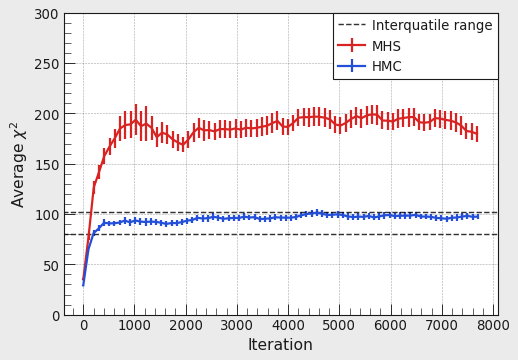

In [720]:
fig, ax = plt.subplots()
ax.errorbar(np.linspace(0, theta_array[:, accepts].shape[1], len(mean_MH)), mean_MH, yerr = std_MH/np.sqrt(50), label = "MHS")
ax.errorbar(np.linspace(0, sam_array.shape[1], len(means)), means, yerr = std/np.sqrt(50), label = "HMC")
ax.set_ylabel("Average $\chi^{2}$")
ax.set_xlabel("Iteration")
# ax.set_title(r"Average $\chi^{2}$ value of 50 dimensions after n iterations" +"\n" + "calculated from the true distributions")
# ax.grid(False)
ylim = ax.get_ylim()
ax.set_ylim(0, 300)
ax.set_xlim(ax.get_xlim())
ax.hlines([102, 80], -1000, 9000, linestyle = "--", alpha = 0.8, color = "k", linewidth = 1.3, label = "Interquatile range")
ax.legend()

plt.savefig("chi2_MHS_and_HMC.pdf", facecolor = "white")
plt.show()

In [587]:
# Test distribution of Chi2 values of 50 gauss with 10000 samples each
np.random.seed(42)
runs = 5000
n_samples = 8000
bins = 100
mu = 0
sigmas = np.linspace(0.01, 1, 50)
def running_chi2_stationary(data, mu, sigma, bins= 100):
    def chi2(expected, y, sy):
        return  np.sum((expected-y)**2/sy**2)
    chi2s = np.zeros(data.shape[0])
    ps = np.zeros(data.shape[0])
    for idx, (row, sigma) in enumerate(zip(data, sigmas)):
        count, edge = np.histogram(row, bins = bins)
        center = (edge[1:] + edge[:-1])/2
        mask = count > 0
        x = center[mask]
        y = count[mask]
        sy = np.sqrt(y)
        scale = (np.max(row)-np.min(row))/bins * data.shape[1]
        expected = stats.norm.pdf(x, mu, sigma)*scale
        chi2s[idx] = chi2(expected, y, sy)
        ps[idx] = stats.chi2.sf(bins, chi2(expected, y, sy))
    chi2_means, chi2_std = np.mean(chi2s), np.std(chi2s)
    return chi2_means, chi2_std, chi2s, ps
chi2_means_list= np.zeros(runs)
for run in range(runs):
    data = np.array([np.random.normal(mu, sigma, n_samples) for sigma in sigmas])
    chi2_means, chi2_std, chi2s, ps = running_chi2_stationary(data, mu, sigma, bins = bins)
    chi2_means_list[run] = chi2_means
    
# scale = (np.max(chi_means_list)-np.min(chi_means_list))/30 * runs
pro25 = np.percentile(chi2_means_list, 25)
pro75 = np.percentile(chi2_means_list, 75)
means_mean = np.mean(chi2_means_list)
print(pro25, pro75)
plt.hist(chi2s, bins = 30, density=True, label = f"$\chi^{2}$, $\mu ={means_mean:.0f}^{{+{pro75-means_mean:.0f}}}_{{-{means_mean-pro25:.0f}}}$")
plt.ylabel("Density")
plt.xlabel(r"$\chi^{2}$ values")
plt.legend()
# plt.savefig("chi2_dist_8000_points_100_bins.pdf", facecolor = "white")
print(ps[-1])

KeyboardInterrupt: 